# PROJECT-3. EDA + Feature Engineering. Kaggle Competition

## 0. Setting up business goal

**Проблема**: Представим, что мы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

**Цель проекта**: построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

**Задачи проекта**:

1. ознакомиться с входными данными
0. выполнить подготовку данных, которые будут использованы для обучения модели
0. изучить пример машинного обучения
0. проверить эффективность предлагаемой модели, используя метрику MAPE
0. принять участие в соревнованиях на площадке kaggle.com

## 1. Exploring the data

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой отзыва и датой выгрузки (2017-08-03);
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as xp
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
# fixing the seed right away
RANDOM_SEED = 42

In [ ]:
# прочитаем данные, запишем их в переменную data и выведем для примера 1 строчку, чтобы иметь представление как выглядят данные
data = pd.read_csv('data/hotels.csv')
data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


## 2. Exploratory data analysis (EDA) and Feature Engineering

In [ ]:
# проверим количество строк и столбцов
data.shape

(386803, 17)

In [ ]:
# попробуем удалить полные дубликаты (если такие имеются). Для проверки выведем обновленное количество строк
data = data.drop_duplicates()
data.shape[0]
# видим, что число строк поменялось, значит мы нашли и удалили полные дубликаты

386496

In [ ]:
# прежде чем приступить к преобразованиям, ознакомимся с представленными признаками, типами данных и количеством заполненных значений
data.info()
# обратим внимание на 2 признака, в которых есть пропуски. от них нужно будет избавиться, иначе модель не сработает корректно

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [ ]:
# проверим признаки на неинформативность
# выведем для ознакомления признаки с порогом в 80% 
#  то есть определим признаки, для которых 80% значений повторяются или 80 % записей уникальны.

low_information_cols = []

for col in data.columns:
    top_freq = data[col].value_counts(normalize = True).max()
    nunique_ratio = data[col].nunique() / data[col].count()
    if top_freq > 0.80:
        low_information_cols.append(col)
        print(f'{col} : {round(top_freq*100,2)}% одинаковых значений')
    if nunique_ratio > 0.80:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100,2)}% уникальных значений')

# данный признак подлежит дальнейшему анализу, тогда как остальные превысили даже уровень в 80%, поэтому на данном этапе оставим данные как есть.


positive_review: 80.66% уникальных значений


#### Hotel_name

In [ ]:
# проанализируем признак на предмет того, может ли он быть полезным
data.hotel_name.value_counts().head(10)

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
Grand Royale London Hyde Park                        2218
Holiday Inn London Kensington                        2097
Hilton London Metropole                              1982
Intercontinental London The O2                       1939
Millennium Gloucester Hotel London                   1889
Name: hotel_name, dtype: int64

In [ ]:
# не во всех отелях название нам о чем-то говорит, за исключением указания города, который мы попытаемся достать из адреса в следующей ячейка, 
# так как не во всех названиях отеля указан город. сразу удалим ненужный более признак
data.drop('hotel_name', axis=1, inplace=True)

#### Hotel_address

In [ ]:
# переименуем колонку hotel_address для упрощения дальнейшего анализа
data.rename(columns={'hotel_address':'address'}, inplace=True)
# выведем в случйном порядке несколько адресов отделей.
print(data['address'].loc[100])
print(data['address'].loc[1000])
print(data['address'].loc[5000])
print(data['address'].loc[7000])
print(data['address'].loc[17000])

# оратим внимание, что последним элементом строки в данной колонке обычно стоит страна, а предпоследним - город. единственное исключение - Англия, где старана - это 2 последних слова,
# а город - 5ое с конца "слово"

5 Curzon St Westminster Borough London W1J 5HL United Kingdom
30 Leinster Gardens Bayswater Westminster Borough London W2 3AN United Kingdom
Prinses Irenestraat 30 Zuideramstel 1077 WX Amsterdam Netherlands
Consell de Cent 498 500 Eixample 08013 Barcelona Spain
K rntnerstra e 18 Eingang Neuer Markt 3 01 Innere Stadt 1010 Vienna Austria


#### City

In [ ]:
# создадим признак город
# применим лямбда функцию к адресу таким озбразом чтобы она возращала предпоследнее слово (город) за исключением ситуаций, где таким словом являет United (UK), 
# для таких случаев вернем 5ое с конца слово
data['city'] = data['address'].apply(lambda x: x.split()[-2] if x.split()[-2] != 'United' else x.split()[-5])
# сразу удалим ненужный более признак с адресом
data.drop('address', axis=1, inplace=True)


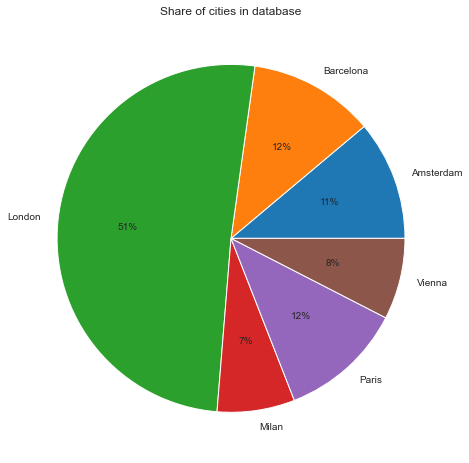

In [ ]:
# выведем полученный дата сет в разрезе по городам
# fig = xp.pie(data, 'city', title='Share of cities in our database')
# fig.show()

cities_grouped = data.groupby('city', as_index=False)['positive_review'].count()
plt.figure(figsize = (14,8))
plt.pie(cities_grouped['positive_review'], labels=cities_grouped['city'], autopct='%.0f%%')
plt.title('Share of cities in database')
plt.show()

#### Population

In [ ]:
# возможно на рейтинг отеля оказывает влияние размер популяции, поэтому возьмем из открытых источников данные о населении в соотвтествующих городах
# сохраним из открытых источников информацию о размере городов и запишем ее в переменную city
city = pd.read_csv('data/city.csv')
# посмотрим как выглядят данные
city.head(3)

,rank,Name,Country,Population,Prev,Growth
0,1,Tokyo,Japan,37274000,37339804,-0.0018
1,2,Delhi,India,32065760,31181376,0.0284
2,3,Shanghai,China,28516904,27795702,0.0259


In [ ]:
# из представленных данных нам понадобится только название города и его размер, поэтому избавимся от остальных данных
city.drop(['rank','Country','Prev','Growth'], axis=1, inplace=True)
# сразу переименуем целевую колонку для упрощения объединения
city.rename(columns={'Name':'city','Population':'population'}, inplace=True)

In [ ]:
# после этого объединим данные с нашей основной таблицей и удалим признак Name, который задвоился из-за операции объединения
data = data.merge(right=city, on='city')
data.population = data.population / 1e6 # выведем значения в миллионах человек
data.head(3)

,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city,population
0,581,2/19/2016,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,London,9.540576
1,299,1/12/2017,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,London,9.540576
2,854,5/18/2017,7.8,United Kingdom,Nothing it was lovely,6,3867,Very central location 2 minutes walk from Glo...,29,4,9.6,"[' Leisure trip ', ' Couple ', ' Double Room N...",77 days,51.494231,-0.185114,London,9.540576


#### City

In [ ]:
# Вернемся к городу. Так как мы использовали этот признак для определения размера населения, а сам по себе строковый признак не сможет быть обработан моделью, попробуем его перекодировать
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

ord_encoder = ce.OrdinalEncoder()
data['city_cat'] = ord_encoder.fit_transform(data['city'])

# признак 'City' пока не удаляем, он нужен нам для работы с широтой и долготой

#### Review_date and Days_since_review

In [ ]:
# Как мы помним формат данного признака object, поэтому для начала приведем его к формату datetime, а затем заберем из него номер месяца
data.review_date = pd.to_datetime(data['review_date'])
# Выведем все значения с максимально датой в колонке review_date и посмотрим какие значения по этим данным у признака days_since_review
data[data.review_date == data.review_date.max()]['days_since_review'].head(3)


422     0 days
1329    0 days
1910    0 days
Name: days_since_review, dtype: object

In [ ]:
# как видим значения везде 0, что означает, что этот признак только считает количество дней, прошедших с даты отзыва. 
# Удалим этот признак за ненадобностью.
data.drop('days_since_review', axis=1, inplace=True)

In [ ]:
# из колонки дата отдыза сделаем месяц отзыва
data.review_date = pd.to_datetime(data['review_date'], format='%Y-%m-%d').dt.month
# Переименуем колонку, чтобы она верно отражала новую суть признака
data.rename(columns={'review_date':'review_month'}, inplace=True)
data.head(3)

,additional_number_of_scoring,review_month,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,lat,lng,city,population,city_cat
0,581,2,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",51.507894,-0.143671,London,9.540576,1
1,299,1,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",51.521009,-0.123097,London,9.540576,1
2,854,5,7.8,United Kingdom,Nothing it was lovely,6,3867,Very central location 2 minutes walk from Glo...,29,4,9.6,"[' Leisure trip ', ' Couple ', ' Double Room N...",51.494231,-0.185114,London,9.540576,1


/Users/zamirich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Axes:title={'center':'Correlation between month number and average reviewer score'}, xlabel='review_month', ylabel='reviewer_score'>

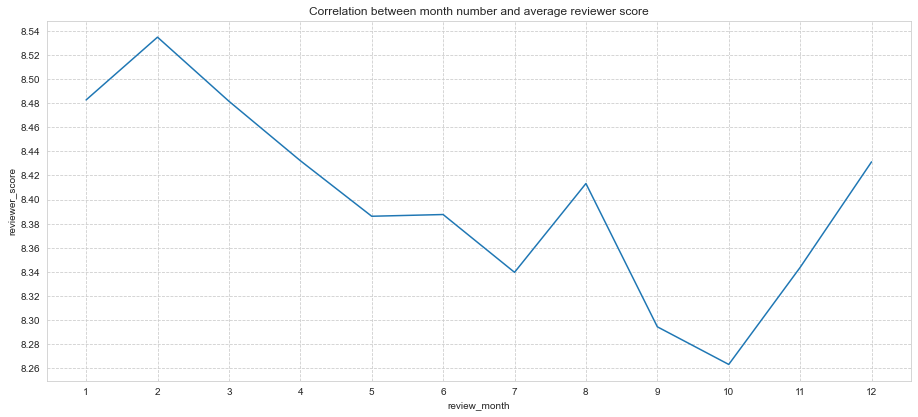

In [ ]:
# Let's see whether there's some strong seasonality of the rating based on number of months
# first, groupping average rating by month number
scores_grouped = data.groupby('review_month', as_index=False)['reviewer_score'].mean()

# drawing the result on the lineplot

import matplotlib.ticker as ticker #importing ticker to change the scale of axises

fig = plt.figure(figsize = (12,5)) #initializing with the plotsize
ax = fig.add_axes([1,1,1,1]) #adding coordinates
ax.set_title('Correlation between month number and average reviewer score') #stting the title
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) #changing the scale of x axis to have 1 day per vertical line
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02)) #changing the scale of y axis to have 0.2 day per horizontal line
sns.set_style("whitegrid", {'grid.linestyle': '--'}) #changing the stile and the grid stile
sns.lineplot(scores_grouped['review_month'], scores_grouped['reviewer_score'], ax=ax) #drawing the plot

#### Reviewer nationality

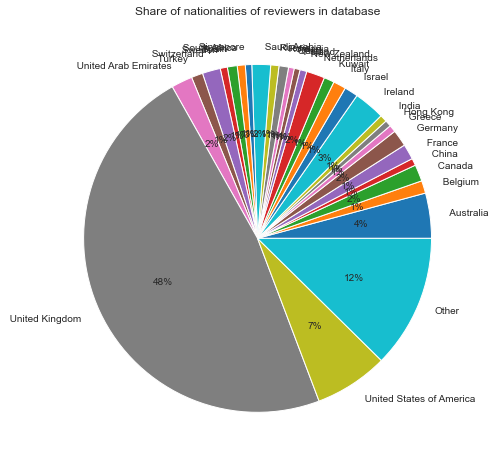

In [ ]:
# сохраним в отдельную переменную страны из которых больше всего туристов, выделив, скажем 9 крупнейших групп
countries_with_most_reviews = data.reviewer_nationality.value_counts().nlargest(29).index.tolist()

# оставим 9 крупнейших групп, остальные заменим на 'Other'
data.reviewer_nationality = data.reviewer_nationality.apply(lambda x: x if x in countries_with_most_reviews else 'Other')

# сгруппируем полученные данные по  национальности пользователя
nationalities_grouped = data.groupby('reviewer_nationality', as_index=False)['positive_review'].count()

# выведем полученные данные на графике
plt.figure(figsize = (14,8))
plt.pie(nationalities_grouped['positive_review'], labels=nationalities_grouped['reviewer_nationality'], autopct='%.0f%%')
plt.title('Share of nationalities of reviewers in database')
plt.show()

In [ ]:
# попробуем проеобразовать признать признак, чтобы модель, смогла исопльзовать его
ord_encoder = ce.OrdinalEncoder()
data['reviewer_cat'] = ord_encoder.fit_transform(data['reviewer_nationality'])

#### lat and lng

In [ ]:
# в силу того, что указанные признаки имеют пропуски, имеет смысл заполнить их средними значениями по городам, 
# так как городов всего 6 и широта с долготой в рамках города не так различается
data['lat'] = data.groupby('city')['lat'].transform(lambda x: x.fillna(x.mean()))
data['lng'] = data.groupby('city')['lng'].transform(lambda x: x.fillna(x.mean()))

__💡IDEA__ точные координаты отелей можно найти, воспользовавшись координатами, которые можно найти из внешних данных, используя адрес отеля, который был представлен в первоначальных данных

In [664]:
# TODO to fill in missing coordinates from the address available

__💡IDEA__ можно добавить признак удаление от центра путем расчетов от представленных координат

In [665]:
# TODO to create a feature on the distance from city center, this should definitely influence the score rating

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386495
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   review_month                                386496 non-null  int64  
 2   average_score                               386496 non-null  float64
 3   reviewer_nationality                        386496 non-null  object 
 4   negative_review                             386496 non-null  object 
 5   review_total_negative_word_counts           386496 non-null  int64  
 6   total_number_of_reviews                     386496 non-null  int64  
 7   positive_review                             386496 non-null  object 
 8   review_total_positive_word_counts           386496 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 

#### Tags

In [ ]:
# TODO we can leverage on this tab, but due to time limitation, we are skipping it (will be removed before fiting the model)

#### Positive and negative review

In [652]:
# воспользуемся библиотекой, анализирующей отзывы на позитивную/негативную тональность
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

data['scores_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['scores_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zamirich/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [653]:
# посмотрим как выглядит новый признак на примере одной записи
print(data['scores_pos'].head(1))

0    {'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...
Name: scores_pos, dtype: object


In [654]:
# как видим выше, каждый признак вернул нам по словарю, состоящему из 4 элементов, сделаем из каждого из них новый признак
data['positive_review_pos']  = data['scores_pos'].apply(lambda x: x['pos'])
data['positive_review_neg']  = data['scores_pos'].apply(lambda x: x['neg'])
data['positive_review_neu']  = data['scores_pos'].apply(lambda x: x['neu'])
data['positive_review_compound']  = data['scores_pos'].apply(lambda x: x['compound'])

data['negative_review_pos']  = data['scores_neg'].apply(lambda x: x['pos'])
data['negative_review_neg']  = data['scores_neg'].apply(lambda x: x['neg'])
data['negative_review_neu']  = data['scores_neg'].apply(lambda x: x['neu'])
data['negative_review_compound']  = data['scores_neg'].apply(lambda x: x['compound'])

# смотрим, что получилось
data.head(1)

,additional_number_of_scoring,review_month,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,scores_pos,scores_neg,positive_review_pos,positive_review_neg,positive_review_neu,positive_review_compound,negative_review_pos,negative_review_neg,negative_review_neu,negative_review_compound
0,581,2,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,"{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.655,0.0,0.345,0.5859,0.0,0.0,1.0,0.0


#### Correlation

<AxesSubplot:title={'center':'Pearson correlation'}>

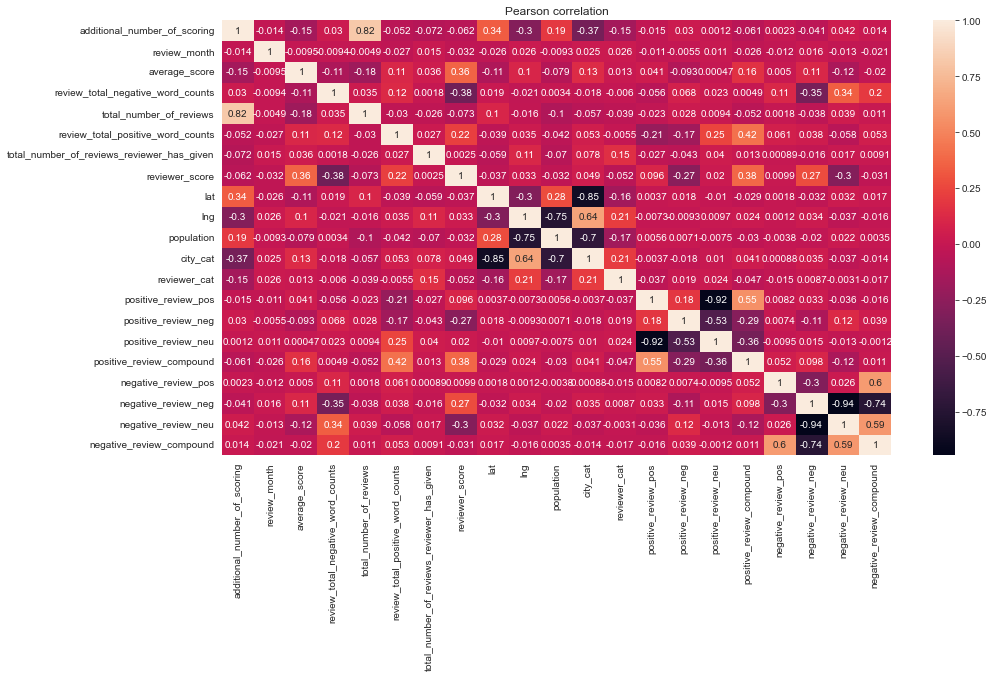

In [655]:
# Расчитаем корреляцию признаков и выведем ее на графике
plt.figure(figsize = (15,8))
plt.title('Pearson correlation')
sns.heatmap(data.corr(), annot=True)

In [656]:
# в наших данных несколько колонок, создающих мультиколлинеарность, избавимся от них
columns_to_delete = ['population','city_cat','additional_number_of_scoring','negative_review_neg', 'positive_review_pos']
data.drop(columns_to_delete, axis=1, inplace=True)

<AxesSubplot:>

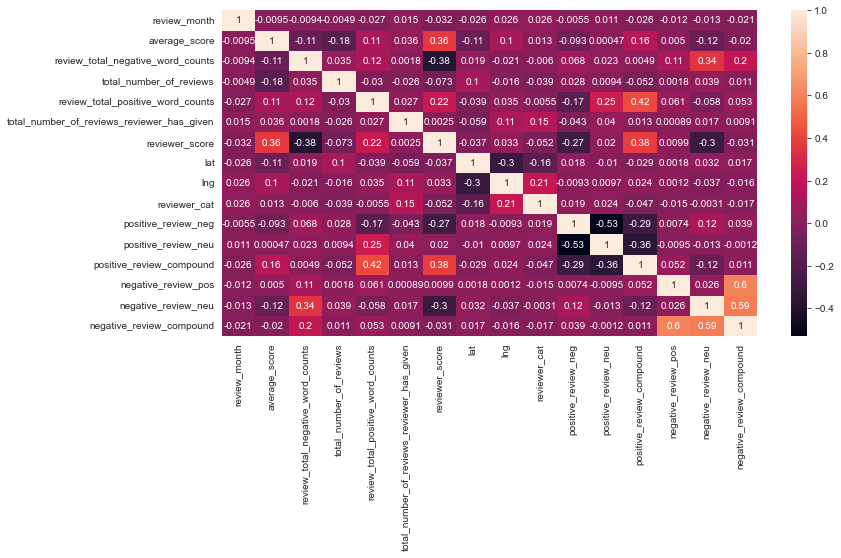

In [657]:
# проверим, что у нас получилось
plt.figure(figsize = (12,6))
sns.heatmap(data.corr(), annot=True)

## 3. Getting the model ready

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

['reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'city', 'scores_pos', 'scores_neg']


In [660]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

In [661]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [662]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 4. Fitting the model

In [666]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [667]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12542336463725207


## 5. Additional analysis

In [668]:
num_cols = ['additional_number_of_scoring','total_number_of_reviews', 'review_total_negative_word_counts','review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given']
cat_cols = ['average_score', 'lat', 'total_number_of_reviews']

<AxesSubplot:>

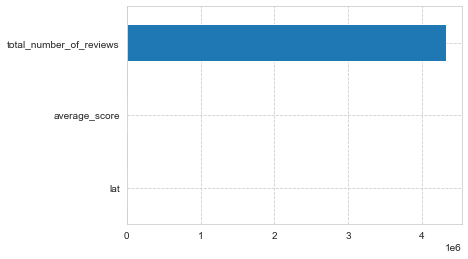

In [669]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

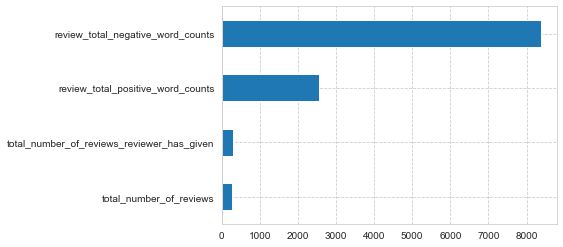

In [670]:
from sklearn.feature_selection import f_classif # anova

num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts','review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given']
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')